In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import yaml
from copy import copy

In [2]:
# load the single LArPix-v2a anode tile yaml file
geometrypath='/global/cfs/cdirs/dune/users/brussell/bern/bern-mod1/layout-2.4.0.yaml'
with open(geometrypath) as fi:
    geo=yaml.full_load(fi)
    chip_pix=dict([(chip_id,pix) for chip_id,pix in geo['chips']])
    vlines=np.linspace(-1*(geo['width']/2), geo['width']/2, 11)
    hlines=np.linspace(-1*(geo['height']/2), geo['height']/2, 11)

In [3]:
# these are dumb manipulations I have put together to tessalate the tiles - others likely use a different approach

tile_dy = abs(max(vlines))+abs(min(vlines))
tile_y_placement = [tile_dy*i for i in range(5)]
mid_y = tile_y_placement[2]
tile_y_placement = [typ-mid_y for typ in tile_y_placement]
mid_vl = tile_dy/2.
chip_y_placement = [typ+vl+mid_vl for typ in tile_y_placement[0:-1] for vl in vlines[0:-1]]

tile_dx = abs(max(hlines))+abs(min(hlines))
tile_x_placement = [tile_dx*i for i in range(3)]
mid_x = tile_x_placement[2]
tile_x_placement = [txp-mid_x for txp in tile_x_placement]
mid_hl = tile_dx/2.
chip_x_placement = [txp+hl+mid_hl for txp in tile_x_placement[0:-1] for hl in hlines[0:-1]]

In [4]:
# there was an installation error at Bern such that tiles 7 & 8 do not follow the regular pattern of even tile IDs in one vertical tile column and odd tile IDs in the other
# this swap on tiles 7 & 8 are exclusive to Module-1 Bern data alone; this has been fixed for 2x2 operation
displacement={1:(-0.5,1.5), 2:(0.5,1.5), 3:(-0.5,0.5), 4:(0.5,0.5), 5:(-0.5,-0.5), 6:(0.5,-0.5), 7:(0.5,-1.5), 8:(-0.5,-1.5)}

In [5]:
def find_xy(tile_id, chip_id, channel_id):
    xc=0; yc=0
    if tile_id in [1,3,5,8]:
        xc=geo['pixels'][chip_pix[chip_id][channel_id]][1]
        yc=geo['pixels'][chip_pix[chip_id][channel_id]][2]*-1
    if tile_id in [2,4,6,7]:
        xc=geo['pixels'][chip_pix[chip_id][channel_id]][1]*-1
        yc=geo['pixels'][chip_pix[chip_id][channel_id]][2]
    xc += tile_dx*displacement[tile_id][0]
    yc += tile_dy*displacement[tile_id][1]
    return xc, yc

In [6]:
### The combination of IO group, IO channel, and chip ID specify a unique ASIC in the system
### IO channels are assigned given the network configuration. This field corresponds to the PACMAN channel upon which data is read in/out from the tile
### IO channel assigned to the asic may change, but the physical tile ID is static; multiple IO channels map to the same tile ID
def io_channel_to_tile(io_channel): return int(np.floor((io_channel-1-((io_channel-1)%4))/4+1))

In [7]:
### all Bern module data has been uploaded to NERSC - a NERSC account is not needed to access
### see this link for click-downloadable files: https://portal.nersc.gov/project/dune/data/Module1/TPC12/dataRuns/packetData/
file2306='/global/cfs/cdirs/dune/www/data/Module1/TPC12/dataRuns/packetData/packet_2022_02_10_22_58_34_CET.h5'
ftimestamp=file2306.split("/")[-1].split('2022_02_10_')[-1].split("_CET")[0]

In [8]:
f=h5py.File(file2306,'r')
io_group_mask=f['packets']['io_group']==1 # selects packets from a specific TPC
packets=f['packets'][io_group_mask]
sync_mask=((packets['packet_type']==6)&(packets['trigger_type']==83)) # selects SYNC packets that are externally generated
sync_idcs=np.argwhere(sync_mask).flatten()
message_groups=np.split(packets, sync_idcs) # partition the packet dataset by sync packet index
print(len(message_groups),' packet groups partitioned by sync packets')

1201  packet groups partitioned by sync packets


In [19]:
def plot_events(sync_group, counter,threshold=500):
    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')
    
    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
    ax[0].stairs(counts, xbins)
    ax[0].set_xlabel('Timestamp')
    ax[0].set_ylabel('Packet count')
    ax[0].set_ylim(0,2e3)
    
    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)
    for i in range(len(physics_bins)): 
        if i!=counter: ax[0].axvline(x=physics_bins[i]*bin_width, alpha=0.5, color='k', linestyle='dashed') # mark all bins exceeding threshold
        if i==counter: ax[0].axvline(x=physics_bins[i]*bin_width, alpha=0.5, color='r', linestyle='dashed') # mark in red bin corresponding to scatter plot hits
    ax[0].axhline(y=threshold, color='g', linestyle='dashed') # denote packet count threshold to categorize as event
    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp

    event_mask=(data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits=data_packets[event_mask]
    io_channel=hits['io_channel']
    tile_id=[io_channel_to_tile(ioc) for ioc in io_channel]
    chip_id=hits['chip_id']
    channel_id=hits['channel_id']
    timestamp=hits['timestamp']
    dataword=hits['dataword'] # ADC value
    print(len(dataword),' hits in event')

    # correlate hardware ID to geometry information to find (x,y) position of hits
    x=[]; y=[]
    for i in range(len(tile_id)):
        xc,yc = find_xy(tile_id[i], chip_id[i], channel_id[i])
        x.append(xc); y.append(yc)
    ax[1].scatter(x,y,s=1); ax[1].set_xlabel('X [mm]'); ax[1].set_ylabel('Y [mm]') 
    ax[2].scatter(timestamp,y,s=1); ax[2].set_ylabel('Y [mm]'); ax[2].set_xlabel(r'Timestamp [0.1 $\mu$s]')
    for i in range(1,3): ax[i].set_ylim(-600,600)
    plt.tight_layout()

    plot_name='sync_'+str(sync_group)+'_threshold_'+str(threshold)+'_event_'+str(counter)+'_timestamp_'+str(ftimestamp)+'.png'
    #plt.savefig(plot_name)

29904  data packets between syncs
5  candidate events
898  hits in event


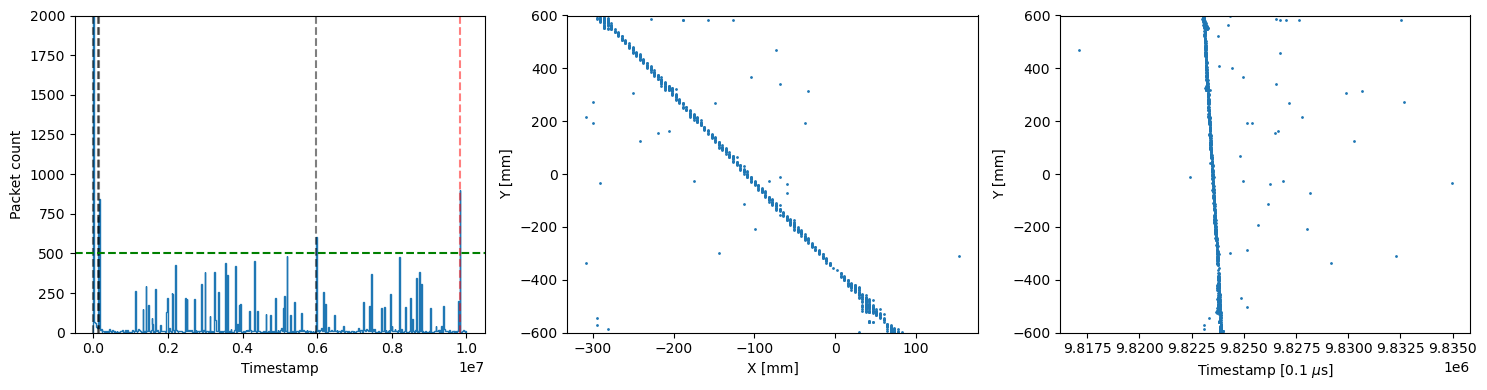

In [21]:
plot_events(481, 4, threshold=500)